In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
np.random.seed(0)
from treePlotter import createPlot
import matplotlib.pyplot as plt
%matplotlib inline
import gc
gc.collect()

11878

In [12]:
watermelon_data = np.array([[0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0],
                                         [1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0],
                                         [2, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1, 1],
                                         [1, 1, 0, 1, 1, 1], [1, 1, 0, 0, 1, 0],
                                         [1, 1, 1, 1, 1, 0], [0, 2, 2, 0, 2, 1],
                                         [2, 2, 2, 2, 2, 0], [2, 0, 0, 2, 2, 1],
                                         [0, 1, 0, 1, 0, 0], [2, 1, 1, 1, 0, 0],
                                         [1, 1, 0, 0, 1, 1], [2, 0, 0, 2, 2, 0],
                                         [0, 0, 1, 1, 1, 0]])

label = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
X_test=np.array([[0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0],
                        [1, 1, 0, 1, 1, 0], [1, 0, 1, 1, 1, 0],
                        [1, 1, 0, 0, 1, 1], [2, 0, 0, 2, 2, 0],
                        [0, 0, 1, 1, 1, 0]])

In [66]:
class DecisionTreeClassifier:
    def __init__(self, tree_type='ID3'):
        self.tree = None
        self.tree_type = tree_type  #决策树种类
        if self.tree_type=='ID3':  #决策树种类对应求gain方法
            self.gain_type = self.Gain  #4.2.1
        elif self.tree_type=='C45':
            self.gain_type = self.Gain_ratio #4.2.2
        elif self.tree_type=='CART':
            self.gain_type = self.Gini_index #4.2.3
    
    def fit(self, X, Y):
        #图4.2 对应输入格式 训练集D 属性集A
        D = {}
        D['X'] = X  
        D['Y'] = Y
        A = np.arange(X.shape[1])
        self.tree = self.TreeGenerate(D, A)   # self.TreeGenerate这种用法？？？？   
        
    def predict(self, X):
        #根据节点编号，进入字典，一直到最终取值
        y_hat = []
        samples = X.shape[0]
        for v in range(samples):
            y_hat.append(self.TreePredict(self.tree, X[v])) #X[v] 一个样本
        return y_hat
        
        
    def TreeGenerate(self, D, A):
        #情形1
        classes = np.unique(D['Y']) #统计有几种label
        n_class = len(classes) #统计类别数
        if n_class==1:
            return classes[0] #选择该特征

        #情形2
        flag = True #判断所有样本在所有属性上值是否相同
        for a in A:
            if len(np.unique(D['X'][:,a])) > 1:
                flag = False
                break
        if len(A)==0 or flag:
            return np.argmax(np.bincount(D['Y'])) #选择类别数最多的特征

        #选择最优划分
        
        #################################################
        Gain = [] #总
        for a in A: #a 为总节点下一个特征  以下计算公式4.2   
            Gain.append(self.gain_type(D, a)) #根据不同类型决策树，计算gain
        #################################################
        
        best_attr = A[np.argmax(Gain)] #选择信息增益最大的特征(要在特征集字段A里选择！！！) 图4.2 第8行；若为C45，做简化处理，最终选择gain_ratio最大的特征
        tree={best_attr:{}}  #每一个结点都创建这样的dict

        subA = np.delete(A, np.argmax(Gain))  #去除best_attr后的属性集
        
        a_best_attr = np.unique(D['X'][:, best_attr])

        for a in a_best_attr: #图4.2 第9行
            slices = np.where(D['X'][:, best_attr]==a)  #该值对应样本索引
            
            #Dv 用来存储其余样本
            Dv = {}
            Dv['X'] = D['X'][slices]  #line 10
            Dv['Y'] = D['Y'][slices]
            if len(Dv['Y']) == 0:
                tree[best_attr][a]=np.argmax(np.bincount(D['Y'])) #为最佳属性 赋值，作为树的判断
            else:
                tree[best_attr][a] = self.TreeGenerate(Dv, subA)
                
        return tree
    
    @classmethod
    def Ent(cls, D):
        pk = np.bincount(D['Y']) / len(D['Y'])
        Ent = 0
        for p in range(len(pk)):
            if pk[p] != 0:
                Ent -= pk[p] * np.log2(pk[p]) #公式4.1
        return Ent
    
    @classmethod
    def Gain(cls, D, a):
        unique = np.unique(D['X'][:, a]) #a字段特征共有多少不同类别的值
        Gain_D = cls.Ent(D) #每一个子类的gain
        Dv_leaf = [] # dv / D
        Ent_leaf = [] #每一个子类的ent
        for u in unique:
            Ent_ = 0
            slices = np.where(D['X'][:, a]==u)  #该值对应样本索引
            Dv_D = len(slices[0]) / len(D['X']) #每个类别所占整体比例为多少 D1 / D
            Dv_leaf.append(Dv_D)
            Dv = {}
            Dv['Y'] = D['Y'][slices]
            Ent_=cls.Ent(Dv)
            Ent_leaf.append(Ent_)

        for u in range(len(unique)):
            Gain_D -= Dv_leaf[u] * Ent_leaf[u] #公式4.2
            
        return Gain_D
    
    @classmethod
    def Gain_ratio(cls, D, a):  
        gain = cls.Gain(D, a)
        
        unique = np.unique(D['X'][:, a]) #a字段特征共有多少不同类别的值
        Dv_leaf = [] # dv / D
        fourth_a= 0
        for u in unique:
            slices = np.where(D['X'][:, a]==u)  #该值对应样本索引
            Dv_D = len(slices[0]) / len(D['X']) #每个类别所占整体比例为多少 D1 / D
            Dv_leaf.append(Dv_D)
           
        for u in range(len(unique)):
            fourth_a -=  Dv_leaf[u] * np.log2(Dv_leaf[u]) #公式4.4
        
        gain_ratio = gain / fourth_a #公式4.3
        return gain_ratio
    
    
    @classmethod
    def Gini(cls, D):
        pk = np.bincount(D['Y']) / len(D['Y'])
        gini = 1
        for p in range(len(pk)):
            if pk[p] != 0:
                gini -= pk[p] * pk[p] #公式4.5
        return gini
        
    @classmethod
    def Gini_index(cls, D, a):
        unique = np.unique(D['X'][:, a]) #a字段特征共有多少不同类别的值
        Gini_D = cls.Gini(D) #每一个子类的gain
        Dv_leaf = [] # dv / D
        Gini_leaf = [] #每一个子类的ent
        for u in unique:
            Gini_ = 0
            slices = np.where(D['X'][:, a]==u)  #该值对应样本索引
            Dv_D = len(slices[0]) / len(D['X']) #每个类别所占整体比例为多少 D1 / D
            Dv_leaf.append(Dv_D)
            Dv = {}
            Dv['Y'] = D['Y'][slices]
            Gini_=cls.Gini(Dv)
            Gini_leaf.append(Gini_)

        for u in range(len(unique)):
            Gini_D += Dv_leaf[u] * Gini_leaf[u] #公式4.6
            
        return -Gini_D #取- ，则在特征选择时选择argmax，和其他决策树保持一致
    

    def TreePredict(self, Ftree, sample):
        
        tree = Ftree
        attr = list(tree.keys())[0] #这一节点的特征字段
        v = sample[attr] #特征字段对应值
        next_tree = tree[attr][v]  #进入字典下一层
        if not isinstance(next_tree, dict): #如果下一层不是字典，那么说明是类别值，则返回预测结果
            return next_tree
        else:
            return self.TreePredict(next_tree, sample)  #如果下一层是字典，那么说明还没到最终，则将这棵树继续递归
        
        
        

{3: {0: {1: {0: 1, 1: {0: {0: 1, 1: {5: {0: 1, 1: 0}}}}, 2: 0}}, 1: {5: {0: 0, 1: 1}}, 2: 0}}


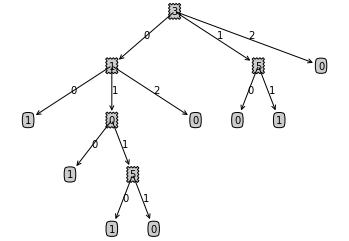

[1, 1, 0, 0, 0, 0, 0]


In [67]:
#numpy
dt = DecisionTreeClassifier(tree_type='CART')
dt.fit(watermelon_data, label)
y_hat  = dt.predict(X_test)

print(dt.tree)
createPlot(dt.tree)
print(y_hat)